# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

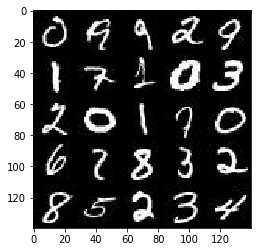

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

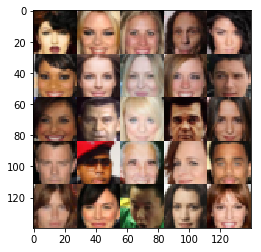

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse) as discriminator_scope:
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    reuse = not is_train
    alpha = 0.2

    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.layers.dense(z, 2*2*512)

        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    samples, losses = [], []
    steps, print_every = 0, 100

    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2

                sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr:learning_rate})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                sess.run(g_opt, feed_dict={input_real:batch_images, input_z: batch_z})

                if steps % 10 == 0:
                # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)


                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5075... Generator Loss: 1.5789
Epoch 1/2... Discriminator Loss: 2.7045... Generator Loss: 0.1692
Epoch 1/2... Discriminator Loss: 2.2003... Generator Loss: 0.1514
Epoch 1/2... Discriminator Loss: 2.4514... Generator Loss: 0.2640
Epoch 1/2... Discriminator Loss: 1.7685... Generator Loss: 0.4259
Epoch 1/2... Discriminator Loss: 1.4084... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.4883... Generator Loss: 0.5159
Epoch 1/2... Discriminator Loss: 1.5026... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 0.8373
Epoch 1/2... Discriminator Loss: 1.6137... Generator Loss: 0.6087


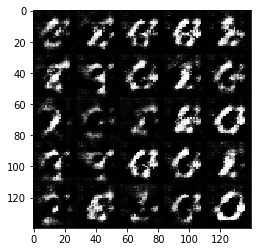

Epoch 1/2... Discriminator Loss: 1.8393... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 1.7465... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 1.0420
Epoch 1/2... Discriminator Loss: 1.5984... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 1.5247... Generator Loss: 0.7931
Epoch 1/2... Discriminator Loss: 1.5279... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 1.6792... Generator Loss: 1.1629
Epoch 1/2... Discriminator Loss: 1.5820... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.7532


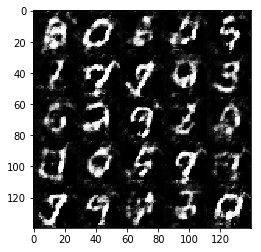

Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 1.0849
Epoch 1/2... Discriminator Loss: 1.5145... Generator Loss: 0.9743
Epoch 1/2... Discriminator Loss: 1.5395... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.5214... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 1.4655... Generator Loss: 0.9059
Epoch 1/2... Discriminator Loss: 1.4802... Generator Loss: 0.9089
Epoch 1/2... Discriminator Loss: 1.5043... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.5188... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.5376... Generator Loss: 1.0760
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.8442


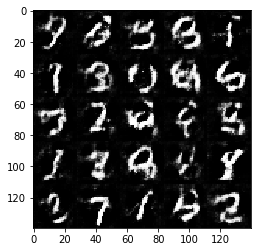

Epoch 1/2... Discriminator Loss: 1.5177... Generator Loss: 1.0128
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 1.4731... Generator Loss: 0.9764
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.9300
Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.7427
Epoch 1/2... Discriminator Loss: 1.5809... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.5564... Generator Loss: 1.0514
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 1.4983... Generator Loss: 0.8925


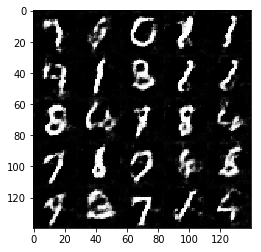

Epoch 1/2... Discriminator Loss: 1.4626... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 1.4780... Generator Loss: 0.8866
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 0.9913
Epoch 1/2... Discriminator Loss: 1.4685... Generator Loss: 0.9559
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.9316
Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.8607
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 0.9333
Epoch 1/2... Discriminator Loss: 1.5244... Generator Loss: 0.9172


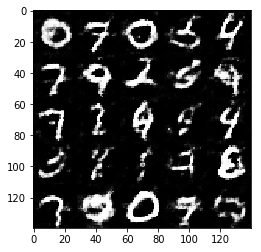

Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.4821... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.4666... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.5442... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.5390... Generator Loss: 0.9324
Epoch 1/2... Discriminator Loss: 1.4712... Generator Loss: 0.9022
Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.4796... Generator Loss: 0.8957


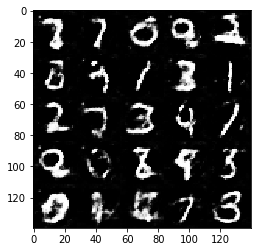

Epoch 1/2... Discriminator Loss: 1.4986... Generator Loss: 0.9778
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.4951... Generator Loss: 0.9709
Epoch 1/2... Discriminator Loss: 1.4869... Generator Loss: 0.8326
Epoch 1/2... Discriminator Loss: 1.4884... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 1.5033... Generator Loss: 1.0048
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 1.0225
Epoch 1/2... Discriminator Loss: 1.4997... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.8824


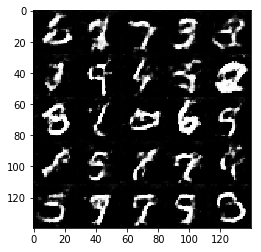

Epoch 1/2... Discriminator Loss: 1.5437... Generator Loss: 1.0285
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.8889
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.9791
Epoch 1/2... Discriminator Loss: 1.5728... Generator Loss: 0.9707
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.9977
Epoch 1/2... Discriminator Loss: 1.4908... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.6528... Generator Loss: 1.1871
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.8761
Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.6671... Generator Loss: 1.2061


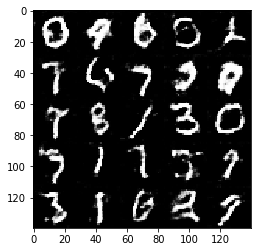

Epoch 1/2... Discriminator Loss: 1.4289... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.6661... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.8126
Epoch 1/2... Discriminator Loss: 1.5211... Generator Loss: 0.8587
Epoch 1/2... Discriminator Loss: 1.5316... Generator Loss: 0.9623
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 0.8897
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.9090
Epoch 1/2... Discriminator Loss: 1.5377... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.5160... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.8228


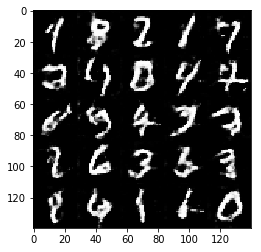

Epoch 1/2... Discriminator Loss: 1.6129... Generator Loss: 1.0614
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.7933
Epoch 1/2... Discriminator Loss: 1.5012... Generator Loss: 0.9655
Epoch 2/2... Discriminator Loss: 1.5461... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.8006
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.6772
Epoch 2/2... Discriminator Loss: 1.5823... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 1.5957... Generator Loss: 0.8756
Epoch 2/2... Discriminator Loss: 1.5392... Generator Loss: 0.8036
Epoch 2/2... Discriminator Loss: 1.4505... Generator Loss: 0.7553


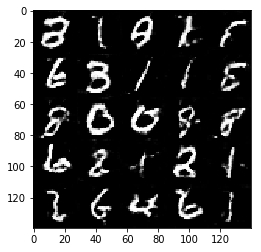

Epoch 2/2... Discriminator Loss: 1.7092... Generator Loss: 0.9983
Epoch 2/2... Discriminator Loss: 1.4708... Generator Loss: 0.6418
Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 2.0158... Generator Loss: 0.1902
Epoch 2/2... Discriminator Loss: 1.4448... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 1.4601... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.5562... Generator Loss: 0.3684
Epoch 2/2... Discriminator Loss: 1.6637... Generator Loss: 0.2948
Epoch 2/2... Discriminator Loss: 1.4466... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.5551... Generator Loss: 0.4121


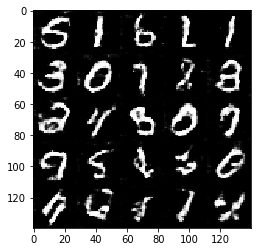

Epoch 2/2... Discriminator Loss: 1.6973... Generator Loss: 0.2923
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.5604
Epoch 2/2... Discriminator Loss: 1.8025... Generator Loss: 0.2374
Epoch 2/2... Discriminator Loss: 1.5674... Generator Loss: 0.3864
Epoch 2/2... Discriminator Loss: 1.5130... Generator Loss: 0.4674
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.3806
Epoch 2/2... Discriminator Loss: 1.5421... Generator Loss: 0.3809
Epoch 2/2... Discriminator Loss: 1.5626... Generator Loss: 0.3757
Epoch 2/2... Discriminator Loss: 1.6858... Generator Loss: 0.2897


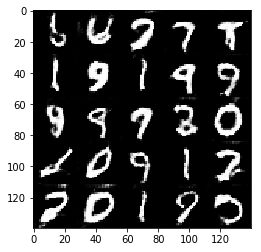

Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 1.4315... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 1.5350... Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 1.5841... Generator Loss: 0.3591
Epoch 2/2... Discriminator Loss: 1.5925... Generator Loss: 0.3491
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 0.4948
Epoch 2/2... Discriminator Loss: 1.3557... Generator Loss: 0.6630
Epoch 2/2... Discriminator Loss: 1.4859... Generator Loss: 0.9427


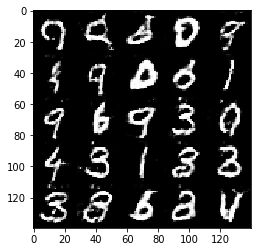

Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.5667... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.5752
Epoch 2/2... Discriminator Loss: 1.5461... Generator Loss: 0.9726
Epoch 2/2... Discriminator Loss: 1.4260... Generator Loss: 0.9672
Epoch 2/2... Discriminator Loss: 1.4336... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.4906... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.5757
Epoch 2/2... Discriminator Loss: 1.4883... Generator Loss: 0.8062
Epoch 2/2... Discriminator Loss: 1.5108... Generator Loss: 1.0033


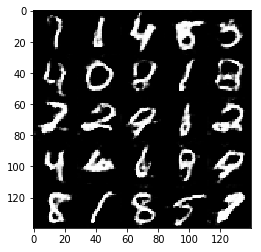

Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.7552
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.4677... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 1.5159... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 1.6543... Generator Loss: 0.3175
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.4507
Epoch 2/2... Discriminator Loss: 1.4602... Generator Loss: 0.4891
Epoch 2/2... Discriminator Loss: 1.4427... Generator Loss: 0.5432
Epoch 2/2... Discriminator Loss: 2.6819... Generator Loss: 1.8710


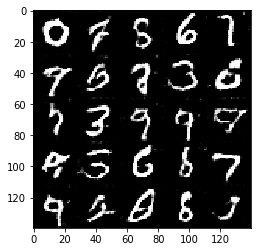

Epoch 2/2... Discriminator Loss: 1.5157... Generator Loss: 0.5765
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.5202
Epoch 2/2... Discriminator Loss: 1.4877... Generator Loss: 0.5176
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.7823
Epoch 2/2... Discriminator Loss: 1.5882... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 1.5741... Generator Loss: 0.3850
Epoch 2/2... Discriminator Loss: 1.8097... Generator Loss: 0.2487
Epoch 2/2... Discriminator Loss: 1.5764... Generator Loss: 0.3444
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 1.6219... Generator Loss: 0.3149


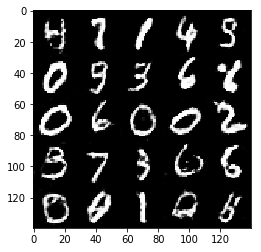

Epoch 2/2... Discriminator Loss: 1.7681... Generator Loss: 0.2667
Epoch 2/2... Discriminator Loss: 1.6025... Generator Loss: 0.3490
Epoch 2/2... Discriminator Loss: 1.4758... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.3403... Generator Loss: 0.5337
Epoch 2/2... Discriminator Loss: 2.0633... Generator Loss: 0.1686
Epoch 2/2... Discriminator Loss: 1.5028... Generator Loss: 0.6162
Epoch 2/2... Discriminator Loss: 1.7385... Generator Loss: 1.0201
Epoch 2/2... Discriminator Loss: 1.3733... Generator Loss: 0.7472
Epoch 2/2... Discriminator Loss: 1.7599... Generator Loss: 0.2700
Epoch 2/2... Discriminator Loss: 1.5585... Generator Loss: 0.3567


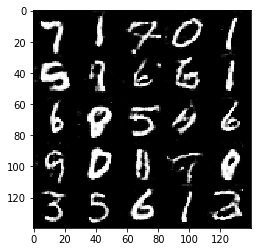

Epoch 2/2... Discriminator Loss: 2.9715... Generator Loss: 2.0724
Epoch 2/2... Discriminator Loss: 1.3893... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.3739... Generator Loss: 0.6877
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 0.8396
Epoch 2/2... Discriminator Loss: 1.5592... Generator Loss: 1.1811
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.5570
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 1.4518... Generator Loss: 0.5277


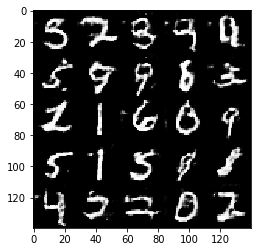

Epoch 2/2... Discriminator Loss: 1.5837... Generator Loss: 0.3773
Epoch 2/2... Discriminator Loss: 1.6346... Generator Loss: 0.2939
Epoch 2/2... Discriminator Loss: 1.5459... Generator Loss: 0.3547
Epoch 2/2... Discriminator Loss: 1.8168... Generator Loss: 0.2496
Epoch 2/2... Discriminator Loss: 1.7049... Generator Loss: 1.1520
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 1.1358
Epoch 2/2... Discriminator Loss: 1.5564... Generator Loss: 0.5794


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.8354... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.9259... Generator Loss: 0.3126
Epoch 1/1... Discriminator Loss: 2.0801... Generator Loss: 0.4085
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.9220... Generator Loss: 0.4178
Epoch 1/1... Discriminator Loss: 1.6650... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.4212
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.6356... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.8184... Generator Loss: 0.4466


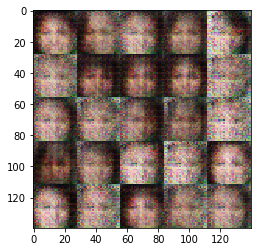

Epoch 1/1... Discriminator Loss: 1.6564... Generator Loss: 0.4799
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.7170
Epoch 1/1... Discriminator Loss: 1.5555... Generator Loss: 0.5265
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.5917... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.7004... Generator Loss: 0.4581
Epoch 1/1... Discriminator Loss: 1.6185... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.5221... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.7373


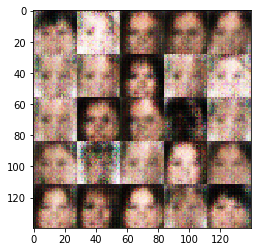

Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.8097
Epoch 1/1... Discriminator Loss: 1.6022... Generator Loss: 0.8313
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.5918... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.5986... Generator Loss: 0.7860
Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.5457... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.6216... Generator Loss: 0.4821
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.5892


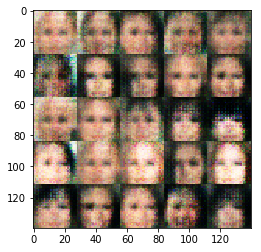

Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 1.4764... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.4853... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6055


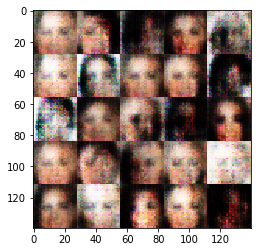

Epoch 1/1... Discriminator Loss: 1.5953... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.5268... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4824... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6437


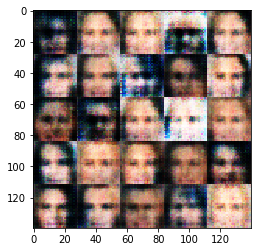

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.5333
Epoch 1/1... Discriminator Loss: 1.8173... Generator Loss: 0.5534
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6092


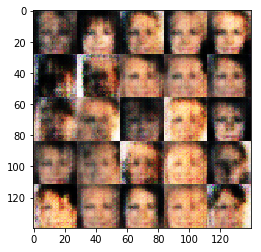

Epoch 1/1... Discriminator Loss: 1.5204... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.5183... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.7046


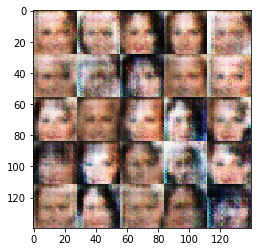

Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4610... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.7208
Epoch 1/1... Discriminator Loss: 1.4701... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7460


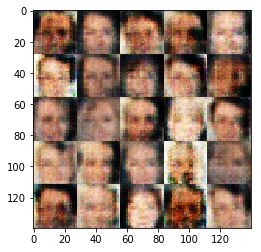

Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.6377... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.5607... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5535


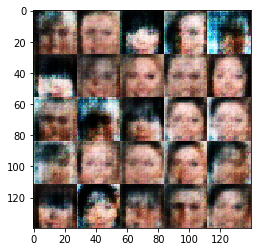

Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4258... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6200
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.4998


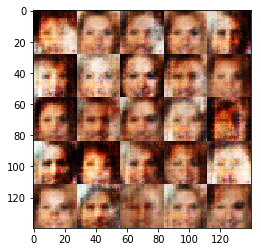

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.6061
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.6702


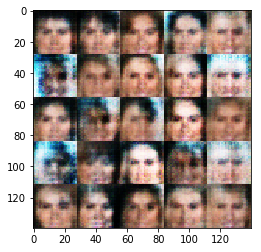

Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.5331... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.4527... Generator Loss: 0.5518


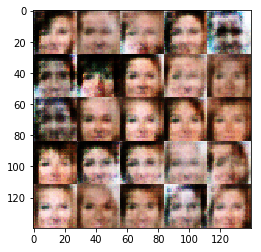

Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6720


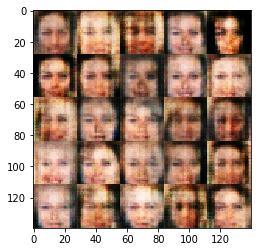

Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.7205
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.4984... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.6114... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6569


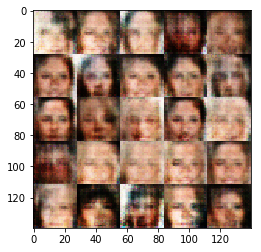

Epoch 1/1... Discriminator Loss: 1.4548... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.7071... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5925


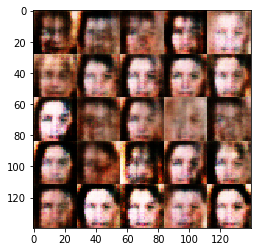

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.7120
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7242


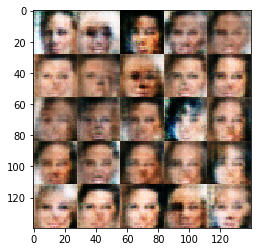

Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.5458
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4448... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.5183


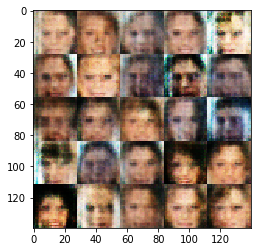

Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.5676
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5826


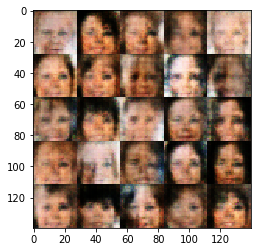

Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.4537... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7166


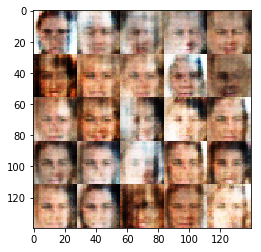

Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6421


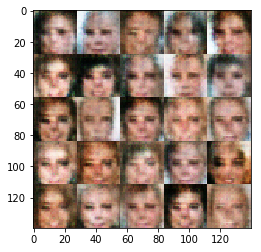

Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.5949
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.5670... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.6441


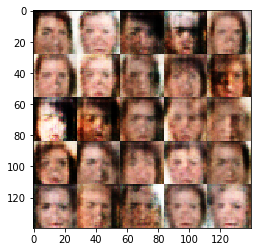

Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.7925
Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7565


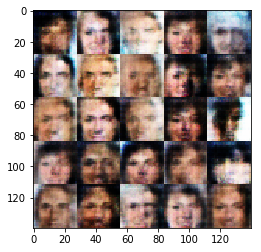

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6350
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5347
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6484
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.7635


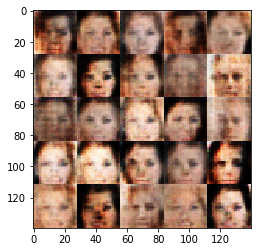

Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.5449... Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5881


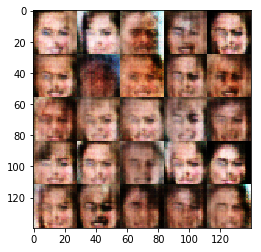

Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.5612
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.5227
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.4964


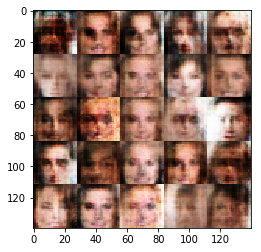

Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.5781
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6440
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.5857


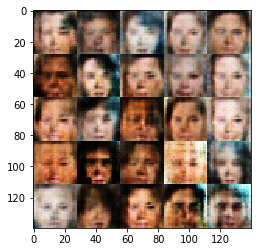

Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6241


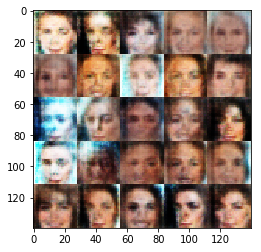

Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.4578
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6727


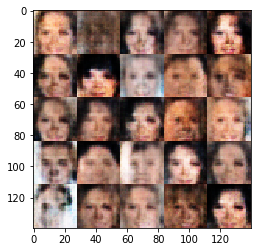

Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.5376


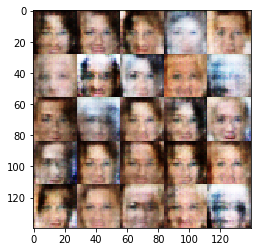

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6633
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6548


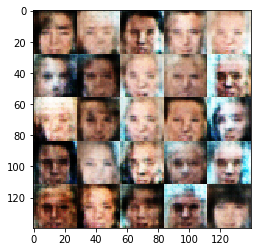

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5980
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6559
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6453


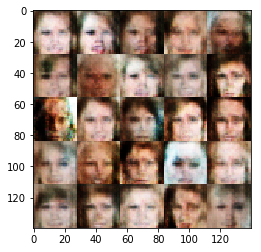

Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.5742


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.